In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c digit-recognizer

 87% 8.00M/9.16M [00:00<00:00, 83.6MB/s]
100% 9.16M/9.16M [00:00<00:00, 83.3MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 113MB/s]
 99% 6.00M/6.09M [00:00<00:00, 60.6MB/s]
100% 6.09M/6.09M [00:00<00:00, 56.0MB/s]


In [6]:
! unzip 'train.csv.zip'
! unzip 'test.csv.zip'

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [7]:
import torch 
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor, Lambda
from torchvision import datasets, transforms

In [8]:
train_ds = pd.read_csv("/content/train.csv")
test_ds = pd.read_csv("/content/test.csv")

In [9]:
train_labels = train_ds['label'].values
train_images = (train_ds.iloc[:,1:].values).astype('float32')
test_images = (test_ds.iloc[:,:].values).astype('float32')
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [10]:
train_images = train_images.reshape(train_images.shape[0], 1, 28, 28)
val_images = val_images.reshape(val_images.shape[0], 1, 28, 28)
test_images = test_images.reshape(test_images.shape[0], 1, 28, 28)

In [11]:
train_images.shape

(33600, 1, 28, 28)

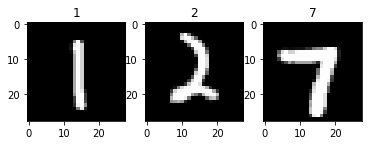

In [12]:
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

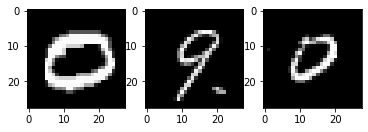

In [13]:
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))

In [14]:
train_images_tensor = torch.Tensor(train_images)/255
val_images_tensor = torch.Tensor(val_images)/255
test_images_tensor = torch.Tensor(test_images)
train_labels_tensor = torch.Tensor(train_labels)
train_labels_tensor = train_labels_tensor.type(torch.LongTensor)
val_labels_tensor = torch.Tensor(val_labels)
val_labels_tensor = val_labels_tensor.type(torch.LongTensor)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

In [15]:
train_dataloader = DataLoader(train_tensor, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_tensor, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_images_tensor, batch_size=64, shuffle=True)

In [16]:
for X, y in train_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [18]:
print(model)

NeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [19]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  correct = 0
  for batch, (X, y) in enumerate(dataloader):

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model):
  size = len(dataloader.dataset)
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301234  [    0/33600]
loss: 1.468313  [ 6400/33600]
loss: 1.267132  [12800/33600]
loss: 1.317546  [19200/33600]
loss: 1.316114  [25600/33600]
loss: 1.230629  [32000/33600]
Test Error: 
 Accuracy: 57.3%, Avg loss: 0.019287 

Epoch 2
-------------------------------
loss: 1.057929  [    0/33600]
loss: 1.263452  [ 6400/33600]
loss: 1.046480  [12800/33600]
loss: 1.208677  [19200/33600]
loss: 1.157017  [25600/33600]
loss: 1.232654  [32000/33600]
Test Error: 
 Accuracy: 57.2%, Avg loss: 0.019240 

Epoch 3
-------------------------------
loss: 1.175180  [    0/33600]
loss: 1.232780  [ 6400/33600]
loss: 1.332628  [12800/33600]
loss: 1.041278  [19200/33600]
loss: 1.260710  [25600/33600]
